Alex Albaugh.  Wayne State.  CHE 5995/7507.  Lecture 18.  Winter 2026.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tqdm.keras import TqdmCallback
import matplotlib.pyplot as plt
import sklearn

Here we are going to use a neural network to tackle a classification problem.  We'll use handwriting classification as an example.  The MNIST data set is a curated dataset of pictures of handwritten digits and their corresponding labels (0, 1, ..., 9).  This data set was originally developed by the National Institute for Standards and Technology (NIST) and it a very common machine learning data set.  It's so common that it can be loaded from the <code>keras</code> library!
Each MNIST input is a 28x28 black and white image of a handwritten digit.  The data set contains 60,000 images for training and 10,000 images for testing.

In [2]:
#load the MNIST dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Let's visualize some of our inputs and labels.

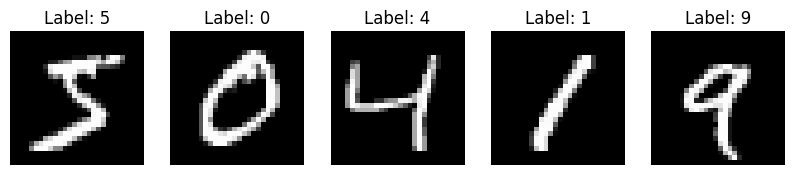

In [3]:
fig,axes = plt.subplots(1, 5, figsize=(10, 3))
for i in range(5):
    axes[i].imshow(X_train[i], cmap='gray')
    axes[i].set_title('Label: '+ str(y_train[i]))
    axes[i].axis('off')
plt.show()

As usual with a neural network, we'll standardize the data first.  The standard scaler expects our features to be flat (1-D arrays), but here we have 2-D photos, so we'll just do the scaling by hand.

Note:  Standard scaling isn't the only choice here.  Because we know that our photo values range from 0 (black) to 255 (white), we could just divide everything by 255 to make all of the values lie between 0 and 1.  This would be a good choice and is one that you can experiment with yourself.

In [4]:
#get the mean and standard deviation from the training data
mu = np.mean(X_train)
sigma = np.std(X_train)

#scale the training and testing data with the mean and standard deviation
X_train, X_test = (X_train-mu)/sigma, (X_test-mu)/sigma

We'll also use <code>sklearn</code>'s <code>to_categorical</code> function to change our labels (0, 1, 2, ..., 9) into one-hot vectors ([1,0,0,...], [0,1,0,...],...).

In [5]:
#one-hot encode the labels
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

Let's set up our neural network.  Here I'll use a very simple 1 layer dense network.  Using more layers or convolutional layers should give better performance.  But this will do surprisingly well.

Our inputs are still 2-D arrays.  So our first layer is a <code>Flatten</code> layer, which simply rearranges the values into a 1-D array.  We then have a standard dense layer with 800 neurons.  Our output layer will have 10 ouputs, one for each category (0,1,2,...,9).  Our activation on this final layer is softmax so that we get an approximation of a one-hot vector out.

We'll also introducing checkpointing here, which we use as a callback during the training.  With checkpointing we save the best performing model from the training procedure and reset to it after training has completed.  To use checkpointing, we use <code>callbacks.ModelCheckpoint</code> along with <code>callbacks</code>, as shown below.

In [6]:
model = keras.Sequential([
  keras.layers.Input(shape=(28, 28)), #input is a 28 x 28 standardized photo
  keras.layers.Flatten(), #we'll take the photo and flatten it into a 1-D vector
  keras.layers.Dense(800, activation='relu'), #the flattened vector goes into a 800-neuron dense layer
  keras.layers.Dense(10, activation='softmax') #our final output is a softmax of the hidden layer output with 10 values- 1 for each category (0, 1, 2,...,9)
])

#stochastic gradient descent solver
solver = keras.optimizers.SGD(learning_rate=0.01)

#early stopping
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

#checkpointing- save the best model (in terms of validation loss) and use that as the final model
checkpoint = keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

#compile with categorical cross-entropy loss, we can also track our accuracy as a metric
model.compile(optimizer=solver, loss='categorical_crossentropy', metrics=['accuracy'])

#fit the model
history = model.fit(X_train, y_train, batch_size=50, epochs=20, validation_split=0.2, verbose=0, callbacks=[TqdmCallback(), checkpoint])

#reset to the best model from training
model = keras.models.load_model('best_model.keras')

#make training predictions
y_pred_train = model.predict(X_train)

#these predictions come out as one-hot vectors
#to get the actual digit value we can use argmax, which will give us the index of the largest value in the predicted one-hot vector
#this index corresponds to the digit
y_pred_train = np.argmax(y_pred_train, axis=1)

#make test predictions
y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(y_pred_test, axis=1)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Let's evaluate our model.  We'll calculate its training and test accuracy.  Accurary is the fraction of data points that the model classifies correctly.  We'll also visualize some of the inputs with the true labels and our predictions.  And we'll finally look at our training and validation loss during the fitting procedure.

Training accuracy:  98.952 %
Test accuracy:  97.72999999999999 %


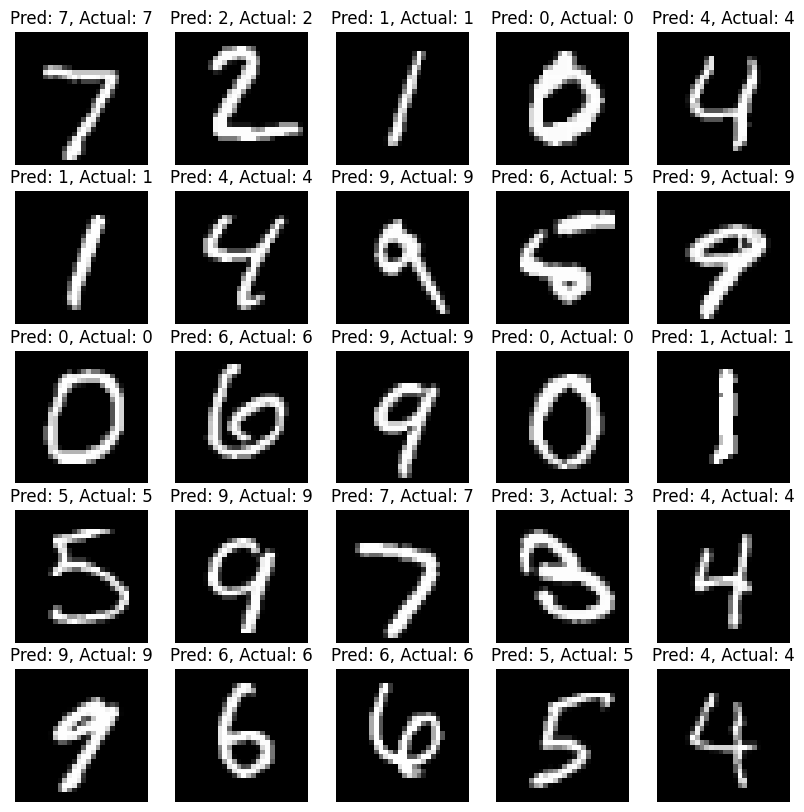

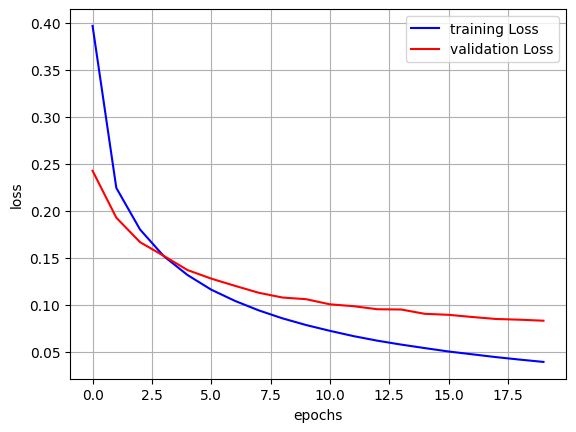

In [7]:
#evaluate model accuracy- what fraction of training data does it get right?
acc = sklearn.metrics.accuracy_score(np.argmax(y_train, axis=1), y_pred_train)
print('Training accuracy: ', 100.0*np.round(acc,decimals=5),'%')

#evaluate model accuracy- what fraction of test data does it get right?
acc = sklearn.metrics.accuracy_score(np.argmax(y_test, axis=1), y_pred_test)
print('Test accuracy: ', 100.0*np.round(acc,decimals=5),'%')

#visualize some predictions
fig,axes = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
  for j in range(5):
    axes[i,j].imshow(X_test[i*5+j], cmap='gray')
    axes[i,j].set_title('Pred: '+str(y_pred_test[i*5+j])+', Actual: '+str(np.argmax(y_test[i*5+j])))
    axes[i,j].axis('off')

#plot training and validation loss during training
fig1,ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='training Loss',color='b')
ax1.plot(history.history['val_loss'], label='validation Loss',color='r')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()
ax1.grid()
plt.show()

The model did pretty well!  Let's specifically look at some incorrect predictions from the test set.

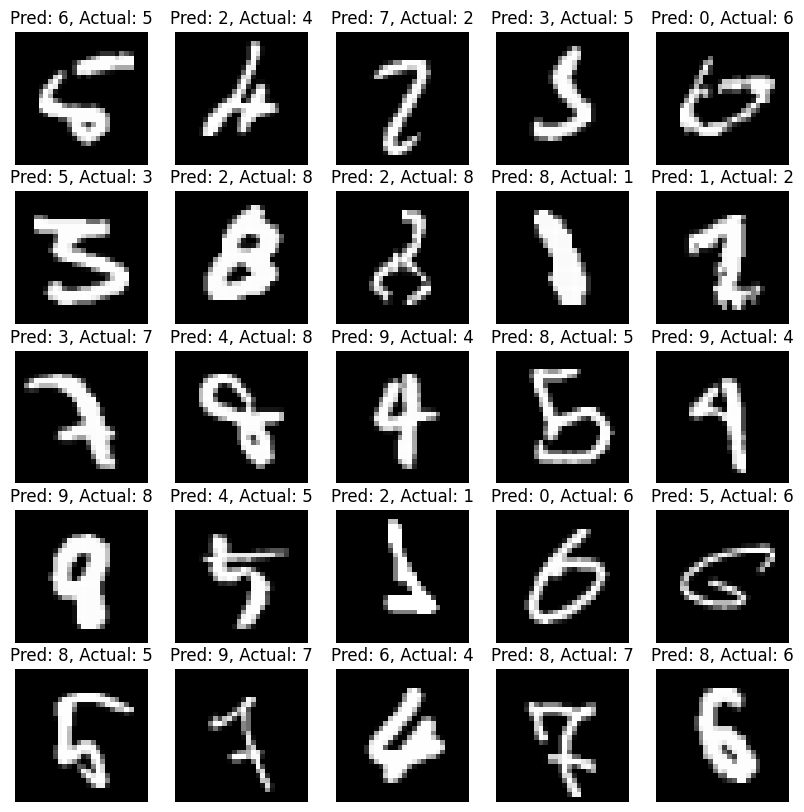

In [8]:
#incorrect pictures are ones where the predictions do not match the true labels
incorrect_predictions = X_test[y_pred_test != np.argmax(y_test, axis=1)]

#incorrect labels do not match the true labels
incorrect_labels = y_pred_test[y_pred_test != np.argmax(y_test, axis=1)]

#we'll also grab the true labels associated with our bad predictions
actual_labels = np.argmax(y_test[y_pred_test != np.argmax(y_test, axis=1)], axis=1)

#visualize some predictions
fig,axes = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
  for j in range(5):
    axes[i,j].imshow(incorrect_predictions[i*5+j], cmap='gray')
    axes[i,j].set_title('Pred: '+str(incorrect_labels[i*5+j])+', Actual: '+str(actual_labels[i*5+j]))
    axes[i,j].axis('off')
plt.show()